## Initial Data Wrangling and preliminary results ##

This notebook contains the initial steps of discovering the data.
It's goal is to look for paterns that could analysed more thoroughly in our data story. 

Main Tools developped:

- Mapping of beer styles to family in BeerAdvocate
- A function that defines the data types in the dataframes created when importing the data 



In [1]:


import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
import my_functions as me # Library with functions created for the project

#load the statistical libraries
from statsmodels.stats import diagnostic
from scipy import stats

## Part 1: Importing the data 

In [2]:
DATA_FOLDER = 'Data/'

RB_FOLDER = DATA_FOLDER + 'RateBeer/'
BA_FOLDER = DATA_FOLDER + 'BeerAdvocate/'
MATCHED_FOLDER = DATA_FOLDER + 'matched_beer_data/'

In [3]:
# Input the data files 

rb_users = pd.read_csv(RB_FOLDER + 'users.csv')
ba_users = pd.read_csv(BA_FOLDER + 'users.csv')
rb_breweries = pd.read_csv(RB_FOLDER + 'breweries.csv')
ba_breweries = pd.read_csv(BA_FOLDER + 'breweries.csv')
rb_beers = pd.read_csv(RB_FOLDER + 'beers.csv')
ba_beers = pd.read_csv(BA_FOLDER + 'beers.csv')

In [4]:
# Import ratings data 

df = me.csv_to_df(BA_FOLDER + 'BA_ratings.csv')

df = df.dropna(subset=['appearance','aroma','palate','taste','overall','rating']) # Drop non-detailed reviews 

# Join location of the brewery 

df = df.join(ba_breweries[['location','id']].set_index('id'), on='brewery_id')
df = df.rename(columns= {'location': 'brewery_location'})

# Join location of the user 

df = df.join(ba_users[['user_id', 'nbr_ratings', 'location']].set_index('user_id'), on = 'user_id')
df =df.rename(columns={'location': 'user_location'})

# Create a column that check if: user is from the same country as the brewery

df['user_beer_country'] = df['brewery_location'] == df['user_location']


## Part 2: Mapping beer family to style on beer ratings in BA 

In [5]:

# Dictionary with mapping of beer substyles to major beer families in BA 

beer_style_mapping = {
"Bocks": ["Bock", "Doppelbock", "Eisbock", "Maibock", "Weizenbock"],
"Brown Ales": ["Altbier", "American Brown Ale", "Belgian Dark Ale", "English Brown Ale", "English Dark Mild Ale"],
"Dark Ales": ["Dubbel", "Roggenbier", "Scottish Ale", "Winter Warmer"],
"Dark Lagers": ["American Amber / Red Lager", "Czech Amber Lager", "Czech Dark Lager", "European Dark Lager", "Märzen", "Munich Dunkel","Euro Dark Lager", "Rauchbier", "Schwarzbier", "Vienna Lager"],
"Hybrid Beers": ["Bière de Champagne / Bière Brut", "Braggot", "California Common / Steam Beer", "Cream Ale"],
"India Pale Ales": ["American IPA", "Belgian IPA", "Black IPA", "Brut IPA", "English IPA", "Imperial IPA", "Milkshake IPA", "New England IPA"],
"Pale Ales": ["American Amber / Red Ale", "American Blonde Ale", "American Pale Ale", "Belgian Blonde Ale", "Belgian Pale Ale", "Bière de Garde", "English Bitter", "English Pale Ale", "English Pale Mild Ale", "Extra Special / Strong Bitter (ESB)", "Grisette", "Irish Red Ale", "Kölsch", "Saison"],
"Pale Lagers": ["American Adjunct Lager","Dortmunder / Export Lager", "Euro Strong Lager", "American Pale Lager", "Czech Pilsener", "German Pilsener", "American Lager", "Bohemian / Czech Pilsner", "Czech Pale Lager", "European / Dortmunder Export Lager", "European Pale Lager","Euro Pale Lager", "European Strong Lager", "Festbier / Wiesnbier", "German Pilsner", "Helles", "Imperial Pilsner", "India Pale Lager (IPL)", "Kellerbier / Zwickelbier", "Light Lager", "Malt Liquor"],
"Porters": ["American Porter", "Baltic Porter", "English Porter", "Imperial Porter", "Robust Porter", "Smoked Porter"],
"Specialty Beers": ["Chile Beer","American Black Ale","Black & Tan", "Pumpkin Ale", "Herbed / Spiced Beer","Low Alcohol Beer", "Fruit / Vegetable Beer", "Fruit and Field Beer", "Gruit / Ancient Herbed Ale", "Happoshu", "Herb and Spice Beer", "Japanese Rice Lager", "Kvass", "Low-Alcohol Beer", "Pumpkin Beer", "Rye Beer", "Sahti", "Smoked Beer"],
"Stouts": ["American Imperial Stout","Milk / Sweet Stout","American Double / Imperial Stout", "American Stout", "English Stout", "Foreign / Export Stout", "Irish Dry Stout", "Oatmeal Stout", "Russian Imperial Stout", "Sweet / Milk Stout"],
"Strong Ales": ["American Barleywine","Belgian Strong Pale Ale","Belgian Strong Dark Ale", "American Strong Ale", "Belgian Dark Strong Ale", "Belgian Pale Strong Ale", "English Barleywine", "English Strong Ale", "Imperial Red Ale", "Old Ale", "Quadrupel (Quad)", "Scotch Ale / Wee Heavy", "Tripel", "Wheatwine"],
"Wheat Beers": ["American Dark Wheat Beer","American Pale Wheat Ale", "American Dark Wheat Ale", "Kristalweizen", "American Pale Wheat Beer", "Dunkelweizen", "Grodziskie", "Hefeweizen", "Kristallweizen", "Witbier"],
"Wild/Sour Beers": ["Berliner Weisse","Berliner Weissbier", "Brett Beer", "Faro", "Flanders Oud Bruin", "Flanders Red Ale", "Fruit Lambic", "Fruited Kettle Sour", "Gose", "Gueuze", "Lambic", "Wild Ale"]
}

restructured_dict = {style: family for family, style in beer_style_mapping.items() for style in style} # Inversing keys and values 


# Applying the function to the DataFrame

df['beer_family'] = df['style'].apply(lambda style: me.map_style_to_family(style, restructured_dict))

## Part 3: Multivariate OLS Regression Analysis on Beer Ratings Dataset

In [6]:
# Regression Analysis 

import statsmodels.formula.api as smf

mod = smf.ols(formula='overall ~ C(user_beer_country) + C(review) + taste * abv + appearance + aroma + palate * abv + nbr_ratings + C(beer_family)',
              data=df)


res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                overall   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                 8.721e+05
Date:                Fri, 17 Nov 2023   Prob (F-statistic):               0.00
Time:                        17:22:17   Log-Likelihood:            -4.4921e+05
No. Observations:             4654808   AIC:                         8.985e+05
Df Residuals:                 4654784   BIC:                         8.988e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

## Part 4:  General Analysis of the users and ratings in both BeerAdvocate and RateBeer 

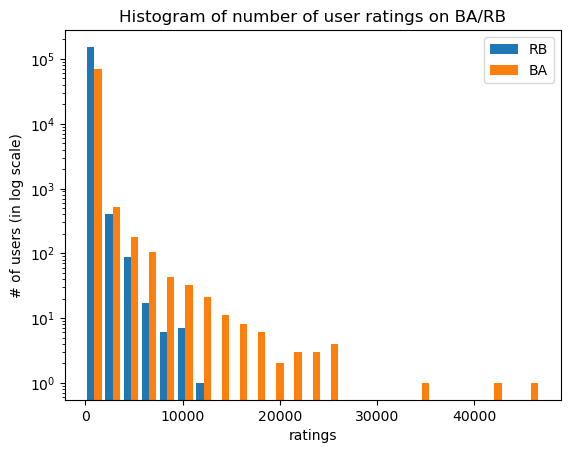

In [7]:
plt.hist([ba_users['nbr_ratings'],rb_users['nbr_ratings']] , bins=25, log=True, stacked=False, histtype='bar', label=['RB','BA'])
plt.title('Histogram of number of user ratings on BA/RB')
plt.ylabel('# of users (in log scale)')
plt.xlabel('ratings')
plt.legend()
plt.show()



In [8]:
print('Number of users (BA|RB): {}|{}\nNumber of ratings (BA|RB): {}|{}'.format( len(ba_users),len(rb_users), ba_users.nbr_ratings.sum(),rb_users.nbr_ratings.sum()))

Number of users (BA|RB): 153704|70174
Number of ratings (BA|RB): 8393032|7636401


## Part 5: Diving Deeper into BeerAdvocate datasets

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


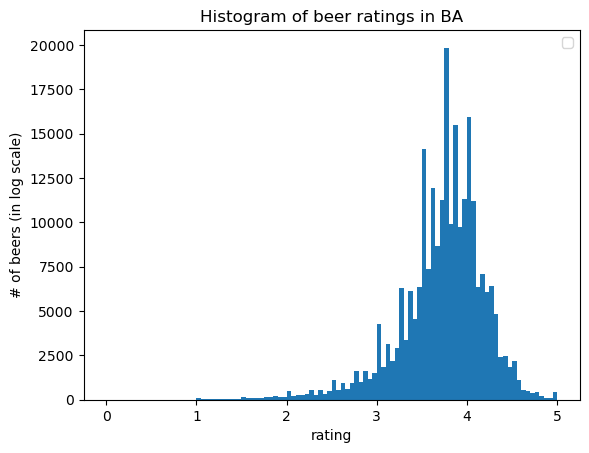

In [9]:
ba_beers = ba_beers[ba_beers['nbr_ratings'] !=0 ]

plt.hist(ba_beers.avg, log=False, bins = 100 )
plt.title('Histogram of beer ratings in BA')
plt.ylabel('# of beers (in log scale)')
plt.xlabel('rating')
plt.legend()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


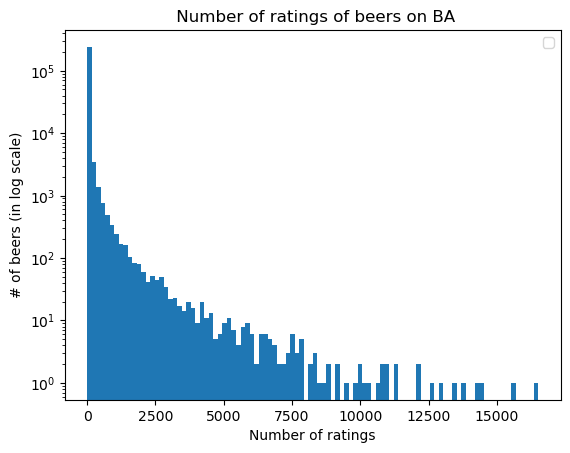

In [10]:
plt.hist(ba_beers.nbr_ratings, log=True, bins = 100 )
plt.title(' Number of ratings of beers on BA')
plt.ylabel('# of beers (in log scale)')
plt.xlabel('Number of ratings')
plt.legend()
plt.show()


In [14]:
rb_beers['style'].unique()

array(['Pale Lager', 'Stout', 'Golden Ale/Blond Ale', 'Bitter',
       'American Pale Ale', 'Irish Ale', 'Wheat Ale',
       'English Strong Ale', 'Black IPA', 'India Pale Ale (IPA)',
       'American Strong Ale ', 'Imperial IPA', 'Berliner Weisse',
       'Sour/Wild Ale', 'Zwickel/Keller/Landbier', 'Saison',
       'Session IPA', 'Imperial Stout', 'Foreign Stout', 'Porter',
       'Spice/Herb/Vegetable', 'Pilsener', 'Belgian Ale', 'Dry Stout',
       'Mild Ale', 'Premium Lager', 'Amber Ale', 'Baltic Porter',
       'California Common', 'Imperial Porter', 'Dortmunder/Helles',
       'Smoked', 'Abbey Tripel', 'Brown Ale', 'Premium Bitter/ESB',
       'Belgian Strong Ale', 'Bière de Garde', 'German Hefeweizen',
       'English Pale Ale', 'Traditional Ale', 'Sweet Stout', 'Kölsch',
       'Altbier', 'Sour Red/Brown', 'Fruit Beer', 'India Style Lager',
       'Lambic Style - Fruit', 'Cider', 'Czech Pilsner (Světlý)',
       'Witbier', 'Cream Ale', 'Scotch Ale', 'Dunkel/Tmavý',
       'Saht